# Classyfing YouTube videos using tags

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from tag_handler import *

In [2]:
from cvs_reader import *
from dataframe_creator import create_seperate_columns, create_listed_columns

# Get dataframes with tags and category_id as columns
ca_csvpath = '/content/CAvideos.csv'
us_csvpath = '/content/USvideos.csv'
gb_csvpath = '/content/GBvideos.csv'

youtube_dfs = [load_dataframe(ca_csvpath, ['tags', 'category_id'])]
youtube_dfs += [load_dataframe(us_csvpath, ['tags', 'category_id'])]
youtube_dfs += [load_dataframe(gb_csvpath, ['tags', 'category_id'])]

# Concat three dataframes into one
tab_dataframe = pd.concat(youtube_dfs, ignore_index=True)
tab_dataframe = tab_dataframe.dropna()
tab_dataframe.head(100)

,tags,category_id
0,Eminem|Walk|On|Water|Aftermath/Shady/Interscop...,10
1,plush|bad unboxing|unboxing|fan mail|idubbbztv...,23
2,racist superman|rudy|mancuso|king|bach|racist|...,23
3,ryan|higa|higatv|nigahiga|i dare you|idy|rhpc|...,24
4,edsheeran|ed sheeran|acoustic|live|cover|offic...,10
5,#DramaAlert|Drama|Alert|DramaAlert|keemstar|yo...,25
6,Funny Moments|Montage video games|gaming|Vanos...,23
7,SHANtell martin,22
8,logan paul vlog|logan paul|logan|paul|olympics...,24
9,God|Sheldon Cooper|Young Sheldon,22


In [3]:
# Remove 'none' values from dataframe
junk = tab_dataframe[tab_dataframe['tags']=='[none]']
tab_dataframe = pd.concat([tab_dataframe, junk, junk]).drop_duplicates(keep=False)
tab_dataframe

,tags,category_id
5,#DramaAlert|Drama|Alert|DramaAlert|keemstar|yo...,25
13,punjabi songs|punjabi bhangra|punjabi music|pu...,10
18,Rooster Teeth|RT|animation|television|filmmaki...,1
24,80s music|80s songs|madonna|DO COLLEGE KIDS KN...,24
26,Industrial Fan|Industrial Fan Destruction|Thro...,24
28,PhillyD|Philly D|Vloggity|The Philip DeFranco ...,22
31,rhett and link|good mythical more|rhett and li...,24
36,Achievement Hunter|AH|video game|gaming|game|g...,20
38,sugar pine 7|steven suptic|autumn|sick|parker|...,24
39,danny duncan|danny duncan 69|kevin|danny dunca...,23


In [0]:
# Spliting dataframe into several dfs based on category_id
dfs = [x for _, x in tab_dataframe.groupby('category_id')]

# deleting 3 categories (29, 30, 43) beacause of lack of frequency
del dfs[14:17]

In [5]:
from sklearn.utils import resample

resampled_dfs = []
for df in dfs:
    resampled_dfs += [resample(df, n_samples=4000)]

# Resampling datas to make them balanced
tab_dataframe = pd.concat(resampled_dfs, axis=0, ignore_index=True)
tab_dataframe

,tags,category_id
0,star wars|star wars 9|star wars episode 9|star...,1
1,la reine blanche saison 3 episode 112|la reine...,1
2,Trailer|2018|Movie|Upcoming Movies|Upcoming Mo...,1
3,mumbai mirchi|crime patrol ep 683|crime patrol...,1
4,mass effect|commander shepard|femshep|garrus v...,1
5,Rooster Teeth|RT|animation|television|filmmaki...,1
6,Unsane|2018|Claire Foy|Juno Temple|Horror|Offi...,1
7,Anarkali|Webseries|web series|kay ray|kayray|d...,1
8,avengers infinity war|avengers infinity war ca...,1
9,tL}4kwsgGx8$28k/|xbenqcatx|the originals 5x01|...,1


In [9]:
from vocab import get_tags_frequency

tag_frequency = get_tags_frequency(tab_dataframe['tags'])
tag_frequency

,category_id,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24
0,1,star wars,star wars 9,star wars episode 9,star wars episode ix,star wars 9 trailer,star wars episode 9 trailer,star wars episode ix trailer,a spark of hope,a spark of hope trailer,star wars 9 teaser trailer,star wars episode 9 teaser trailer,star wars episode ix teaser trailer,a spark of hope teaser trailer,star wars a spark of hope,new star wars movie,star wars trailer,star wars teaser trailer,star wars 9 official trailer,star wars 9 official teaser trailer,notags,notags,notags,notags,notags,notags
1,1,la reine blanche saison 3 episode 112,la reine blanche episode 112,reine 112,reine blanche 112,la reine blanche,la reine blanche saison 3,humour,les déballeurs,cercle vicieux,ennemis intimes,cameroun,douala,mitoumba,wilson,ebenezer kepombia,caroline,canal 2,bigmop,serie tv,serietv,amour,drame,2018,afrique,kamga
2,1,Trailer,2018,Movie,Upcoming Movies,Upcoming Movies 2018,Disney,Disney Movie,Best Upcoming Movies,Best Upcoming Movies 2018,Disney Movies,Disney Movies 2018,Best Disney Movies,Best Disney Movies 2018,Animation,Animated,Animated Movie,Kids,Family,Trailer 2018,Trailers 2018,Christopher Robin,Winnie The Pooh,Incredibles 2,Ralph Breaks The Internet,Mary Poppins Returns
3,1,mumbai mirchi,crime patrol ep 683,crime patrol episode 683,crime patrol 3rd January 2018,crime patrol episode 683 3rd January 2018,Crime Patrol,crime patrol dial 100 3rd January 2018,crime patrol dial 100 ep 683,crime patrol dial 100 ep 683 3rd January 2018,crime,patrol,dial 100,3rd January,3rd January 2018,crime patrol January 2018,crime patrol 2018 latest episode this week,crime patrol full episode,crime patrol 2018 January,notags,notags,notags,notags,notags,notags,notags
4,1,mass effect,commander shepard,femshep,garrus vakarian,conversation,voice acting,totalspiffage,tamara fritz,jabberwockyx,tumblr,mako,launch off a cliff,dare,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
5,1,Rooster Teeth,RT,animation,television,filmmaking,games,video games,comics,austin,texas,production,movies,web series,RT Podcast,podcast,live,Rooster Teeth Podcast,trivia,science,fun facts,Gus Sorola,Burnie Burns,Barbara Dunkelman,Gavin Free,studio
6,1,Unsane,2018,Claire Foy,Juno Temple,Horror,Official,Trailer,Movie,Clip,TV Spot,International,Film,Teaser,Thriller,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
7,1,Anarkali,Webseries,web series,kay ray,kayray,dating,romcom,romantic,comedy,brampton,jotykay,joty kay,tvf,the viral fever,theviralfever,yfilms,bangbaajabaaraat,aib,all india bakchod,iisuperwomanii,browngirllifts,brown girl lifts,manpreet toor,manpreettoor,notags
8,1,avengers infinity war,avengers infinity war cast,funny moments,avengers,avengers funny,avengers play family feud,jimmy kimmel,jimmy kimmel family feud avengers,avengers infinity war cast funny moments,avengers infinity war cast funny,chris hemsworth funny,chris pratt funny,avengers infinity war cast play,family feud,avengers play,mark ruffalo funny,play,games,quiz,marvel quiz,know nothing,infinity war cast,infinity war cast play,infinity war cast funny,fun
9,1,tL}4kwsgGx8$28k/,xbenqcatx,the originals 5x01,klaroline reunion,klaus caroline 5x01,the originals 5x01 klaus caroline,klaroline the originals,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags


In [6]:
max_of_tags = 25

tab_dataframe = create_seperate_columns(tab_dataframe, max_of_tags, 'tags')
tab_dataframe

,category_id,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,tag_10,tag_11,tag_12,tag_13,tag_14,tag_15,tag_16,tag_17,tag_18,tag_19,tag_20,tag_21,tag_22,tag_23,tag_24
0,1,star wars,star wars 9,star wars episode 9,star wars episode ix,star wars 9 trailer,star wars episode 9 trailer,star wars episode ix trailer,a spark of hope,a spark of hope trailer,star wars 9 teaser trailer,star wars episode 9 teaser trailer,star wars episode ix teaser trailer,a spark of hope teaser trailer,star wars a spark of hope,new star wars movie,star wars trailer,star wars teaser trailer,star wars 9 official trailer,star wars 9 official teaser trailer,notags,notags,notags,notags,notags,notags
1,1,la reine blanche saison 3 episode 112,la reine blanche episode 112,reine 112,reine blanche 112,la reine blanche,la reine blanche saison 3,humour,les déballeurs,cercle vicieux,ennemis intimes,cameroun,douala,mitoumba,wilson,ebenezer kepombia,caroline,canal 2,bigmop,serie tv,serietv,amour,drame,2018,afrique,kamga
2,1,Trailer,2018,Movie,Upcoming Movies,Upcoming Movies 2018,Disney,Disney Movie,Best Upcoming Movies,Best Upcoming Movies 2018,Disney Movies,Disney Movies 2018,Best Disney Movies,Best Disney Movies 2018,Animation,Animated,Animated Movie,Kids,Family,Trailer 2018,Trailers 2018,Christopher Robin,Winnie The Pooh,Incredibles 2,Ralph Breaks The Internet,Mary Poppins Returns
3,1,mumbai mirchi,crime patrol ep 683,crime patrol episode 683,crime patrol 3rd January 2018,crime patrol episode 683 3rd January 2018,Crime Patrol,crime patrol dial 100 3rd January 2018,crime patrol dial 100 ep 683,crime patrol dial 100 ep 683 3rd January 2018,crime,patrol,dial 100,3rd January,3rd January 2018,crime patrol January 2018,crime patrol 2018 latest episode this week,crime patrol full episode,crime patrol 2018 January,notags,notags,notags,notags,notags,notags,notags
4,1,mass effect,commander shepard,femshep,garrus vakarian,conversation,voice acting,totalspiffage,tamara fritz,jabberwockyx,tumblr,mako,launch off a cliff,dare,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
5,1,Rooster Teeth,RT,animation,television,filmmaking,games,video games,comics,austin,texas,production,movies,web series,RT Podcast,podcast,live,Rooster Teeth Podcast,trivia,science,fun facts,Gus Sorola,Burnie Burns,Barbara Dunkelman,Gavin Free,studio
6,1,Unsane,2018,Claire Foy,Juno Temple,Horror,Official,Trailer,Movie,Clip,TV Spot,International,Film,Teaser,Thriller,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags
7,1,Anarkali,Webseries,web series,kay ray,kayray,dating,romcom,romantic,comedy,brampton,jotykay,joty kay,tvf,the viral fever,theviralfever,yfilms,bangbaajabaaraat,aib,all india bakchod,iisuperwomanii,browngirllifts,brown girl lifts,manpreet toor,manpreettoor,notags
8,1,avengers infinity war,avengers infinity war cast,funny moments,avengers,avengers funny,avengers play family feud,jimmy kimmel,jimmy kimmel family feud avengers,avengers infinity war cast funny moments,avengers infinity war cast funny,chris hemsworth funny,chris pratt funny,avengers infinity war cast play,family feud,avengers play,mark ruffalo funny,play,games,quiz,marvel quiz,know nothing,infinity war cast,infinity war cast play,infinity war cast funny,fun
9,1,tL}4kwsgGx8$28k/,xbenqcatx,the originals 5x01,klaroline reunion,klaus caroline 5x01,the originals 5x01 klaus caroline,klaroline the originals,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags,notags


In [0]:
future_df = []
col_row_dict = {}
# We only use 1/4 of the dataset!
first_half_df = tab_dataframe
# second_half_df = tab_dataframe[28000:]

In [0]:
for i in range(0, 10010):
    for col in first_half_df.columns:
        if col == 'category_id':
            col_row_dict.update({'category_id':first_half_df[col][i]})
        else:
            col_row_dict.update({'{}'.format(first_half_df[col][i]):1.0})
    future_df.append(col_row_dict)
    col_row_dict = {}

In [10]:
final_dataframe = pd.DataFrame(future_df)
final_dataframe.fillna(0.0, inplace = True)
final_dataframe.head()

,,070118 💖,080118 💖,101217 💚,140118 💖,150118 💖,171217 💚,261117 💚,Anderson Cooper 360,Anwar Jibawi,Byg Byrd,CNN Anderson Cooper 12\ 26\17,Châu Giang - Kim Hải,Chí Vinh - Lê Huỳnh,College Kids Vs Food,College Kids Vs. Food,Derb : Episode 23,Eastern Conference Semifinals: Raptors (1) vs. Cavaliers (4),Elixir Sulfanilamide,Ginni Kapoor,Hannah Stocking,Himanshi Khurana,Hồng Phóng - Hồng Nhung,Kids Vs. Food,Kim Trọng - Kiều Khanh,Lele Pons,Lele Pons & Hannah Stocking,Minh Luân - Kim Thoa,Mueller's Probe and Trump's Lying,Mạnh Định - Thị Ý,New Punjabi Songs 2018,New Punjabi songs 2018,New Songs 2018,Official Music Video,Official Trailer 2,Overwatch,PTR Hero Changes,Quang Sử - Trần Thùy,Quốc Thới - Mỹ Hiền,Rudy Mancuso,...,판문점,판문점 선언,판문점 통일각,평양,평양 공연,평양 공연 봄이 온다,평양공연 풀영상,평창,평창동계올림픽,평창올림픽,평창올림픽 금메달,포니메이크업,포니신드롬,포니화장법,포옹,포크포크,풀버전,하이라이트,하트셰이커,하트셰이커 teaser,하트셰이커 티저,한국,한국말,한류,한미,한미 정상회담,한우,한혜진,한호현,항정살,해찬,행주,헨리,호일,화제,환호,효리네민박,효린,흥행기록,힙합
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
from input_generator import load_dataset_with_lables


# Create train,validation and test examples from tags and labels dataframe
(train_ds, train_lb), (val_ds, val_lb), (test_ds, test_lb) = load_dataset_with_lables(final_dataframe, 'category_id')

In [12]:
train_ds.values

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
train_lb.values

array([17, 24, 27, ..., 26, 19, 27])

In [14]:
hidden = 128
model = tf.keras.Sequential([
    layers.Flatten(),
    layers.Dense(hidden,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(hidden,activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(2*hidden,activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(44, activation='softmax')])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              )

history = model.fit(train_ds.values, train_lb.values,
                    batch_size=32,
                    epochs=6,
                    validation_data=(val_ds.values, val_lb.values))


W0818 09:07:01.028786 140353153513344 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 6006 samples, validate on 2002 samples
Epoch 1/6
6006/6006 [==============================] - 17s 3ms/sample - loss: 2.6569 - acc: 0.2488 - val_loss: 1.3601 - val_acc: 0.7642
Epoch 2/6
6006/6006 [==============================] - 15s 3ms/sample - loss: 1.0972 - acc: 0.7324 - val_loss: 0.7584 - val_acc: 0.8671
Epoch 3/6
6006/6006 [==============================] - 16s 3ms/sample - loss: 0.6198 - acc: 0.8864 - val_loss: 0.6716 - val_acc: 0.8811
Epoch 4/6
6006/6006 [==============================] - 16s 3ms/sample - loss: 0.4332 - acc: 0.9421 - val_loss: 0.6579 - val_acc: 0.8861
Epoch 5/6
6006/6006 [==============================] - 16s 3ms/sample - loss: 0.3419 - acc: 0.9659 - val_loss: 0.6532 - val_acc: 0.8846
Epoch 6/6
6006/6006 [==============================] - 15s 3ms/sample - loss: 0.2830 - acc: 0.9765 - val_loss: 0.6352 - val_acc: 0.8846


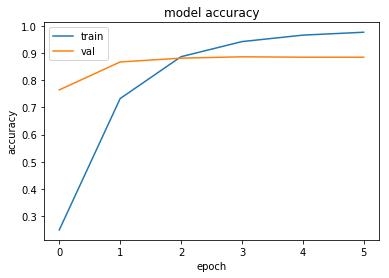

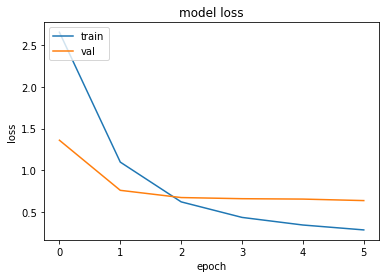

In [15]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.plot(acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
results = model.evaluate(test_ds, test_lb)

print(results)

2002/2002 [==============================] - 2s 1ms/sample - loss: 0.6205 - acc: 0.8856
[0.6205087210629489, 0.8856144]


In [0]:
predictions = model.predict(test_ds)
cat_tit_dict = get_category_title_dict('/content/CA_category_id.json')
cat_tit_dict.update(get_category_title_dict('/content/US_category_id.json'))
cat_tit_dict.update(get_category_title_dict('/content/GB_category_id.json'))

In [0]:
def one_hot_to_index(one_hot):
    i_tags = []
    for i, b in enumerate(one_hot):
        if b == 1.0:
          i_tags.append(i)      
    return i_tags

def index_to_tag(i_tags):
  w_tags = []
  reversed_vocab_dict = {i: vo for vo, i in voc_di.items()}
  for index in i_tags:
    if index != 32193 and 44128:
      
      w_tags.append(reversed_vocab_dict[index])
  return w_tags


In [29]:
for i in range(30, 40):
    one_hot = one_hot_to_index(test_ds.values[i])
    tags_i = index_to_tag(one_hot)
    print(tags_i)
    print('predict:{}'.format(cat_tit_dict[str(np.argmax(predictions[i]))]))
    print('true label:{}'.format(cat_tit_dict[str(test_lb.values[i])]))

KeyError: ignored

# Classifying using tags, number of likes and number of comments


In [0]:
full_dataframe = load_dataframe(csvpath, ['tags', 'likes', 'comment_count', 'category_id'])
max_of_tags = 25

full_dataframe = create_seperate_columns(full_dataframe, max_of_tags, 'tags')

full_dataframe.head()